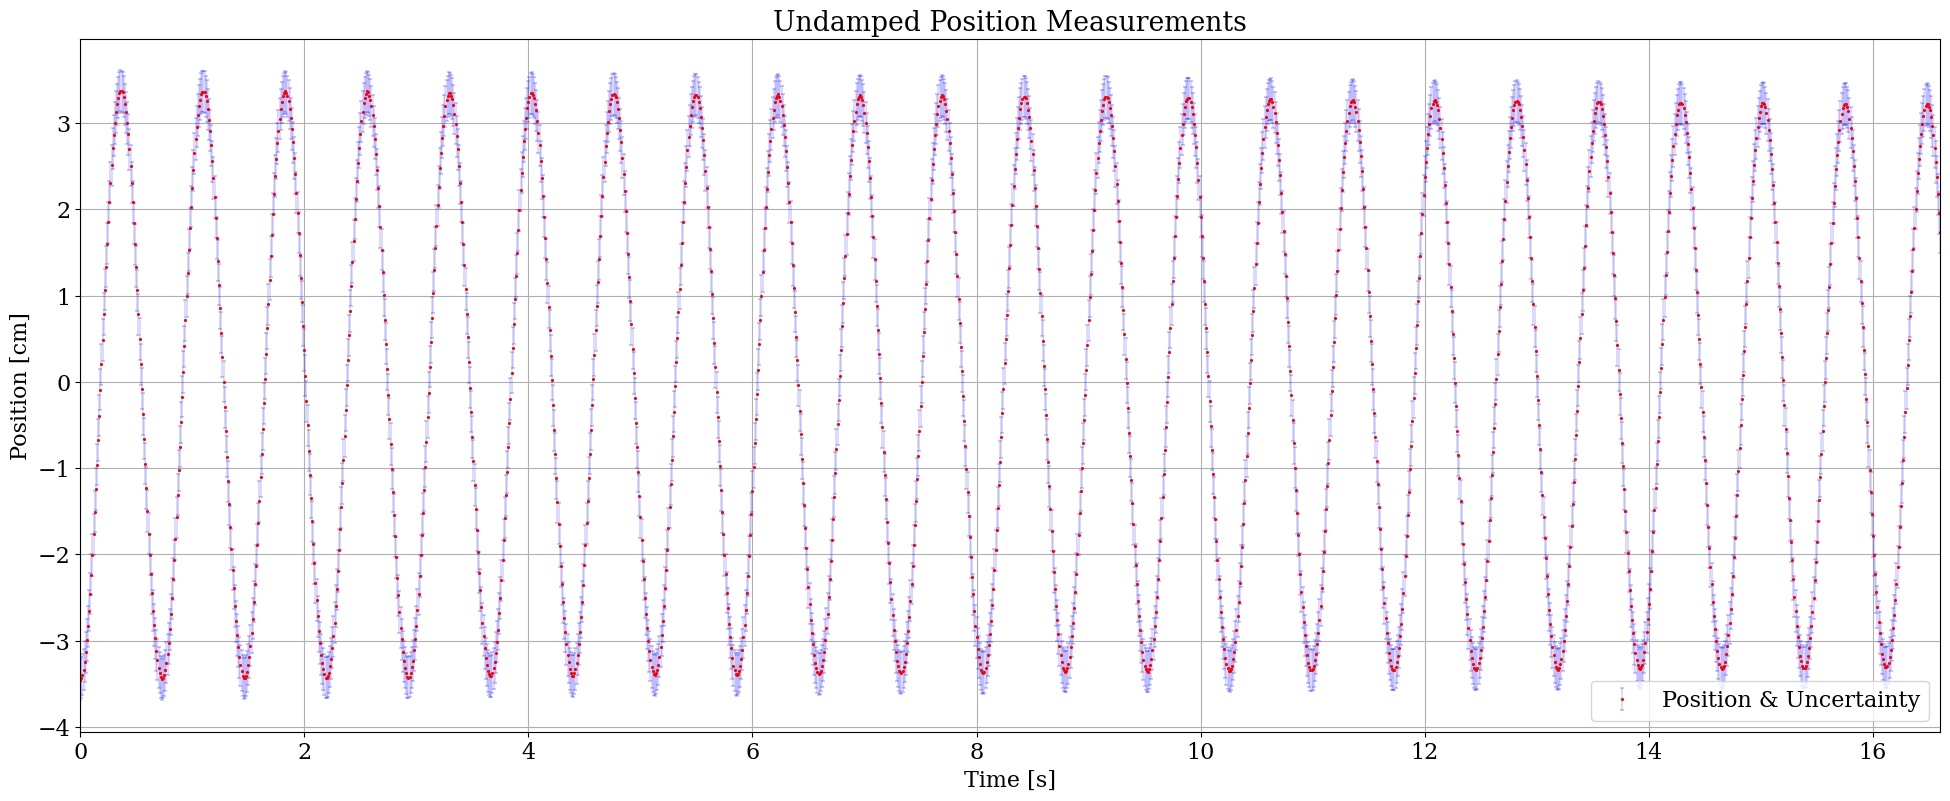

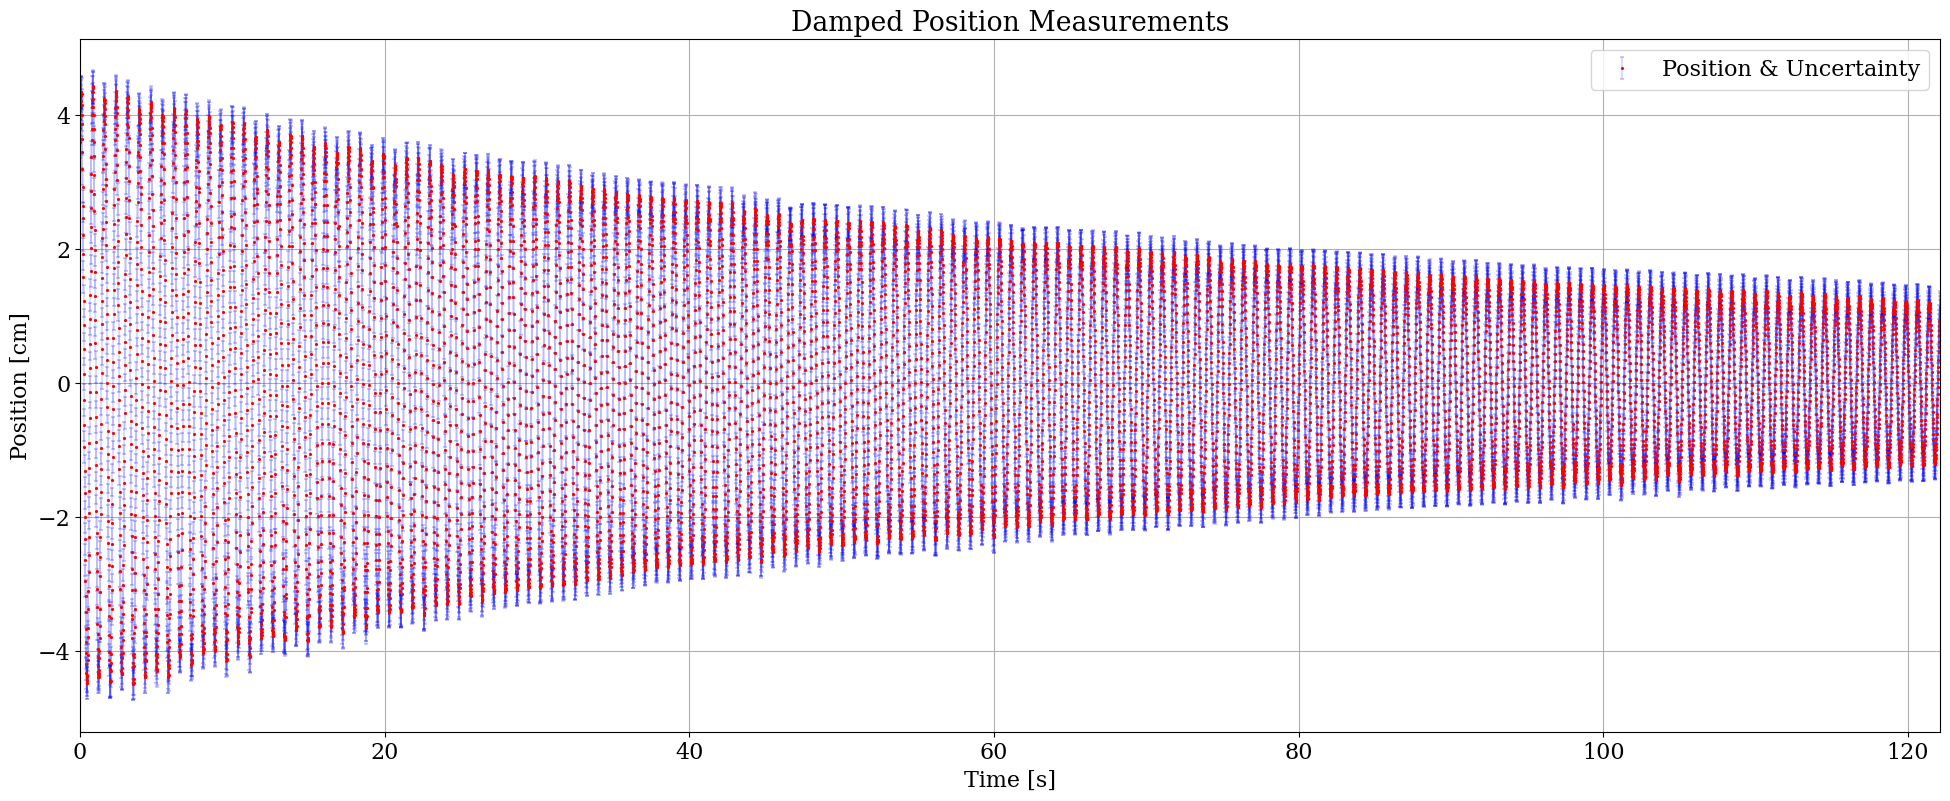

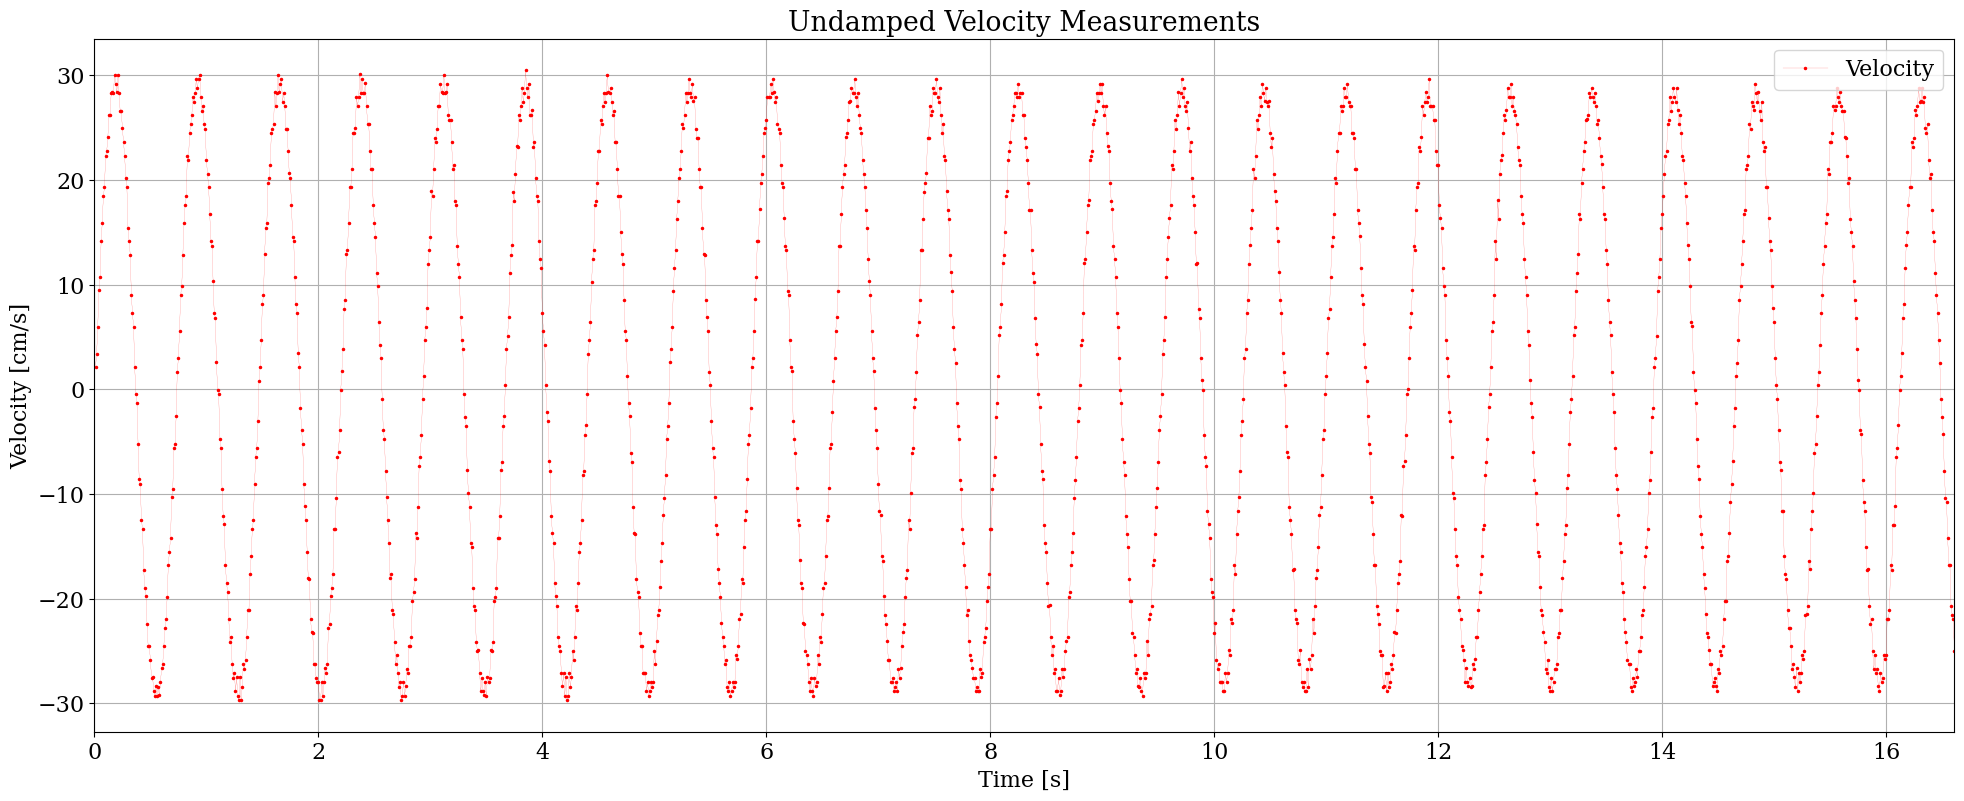

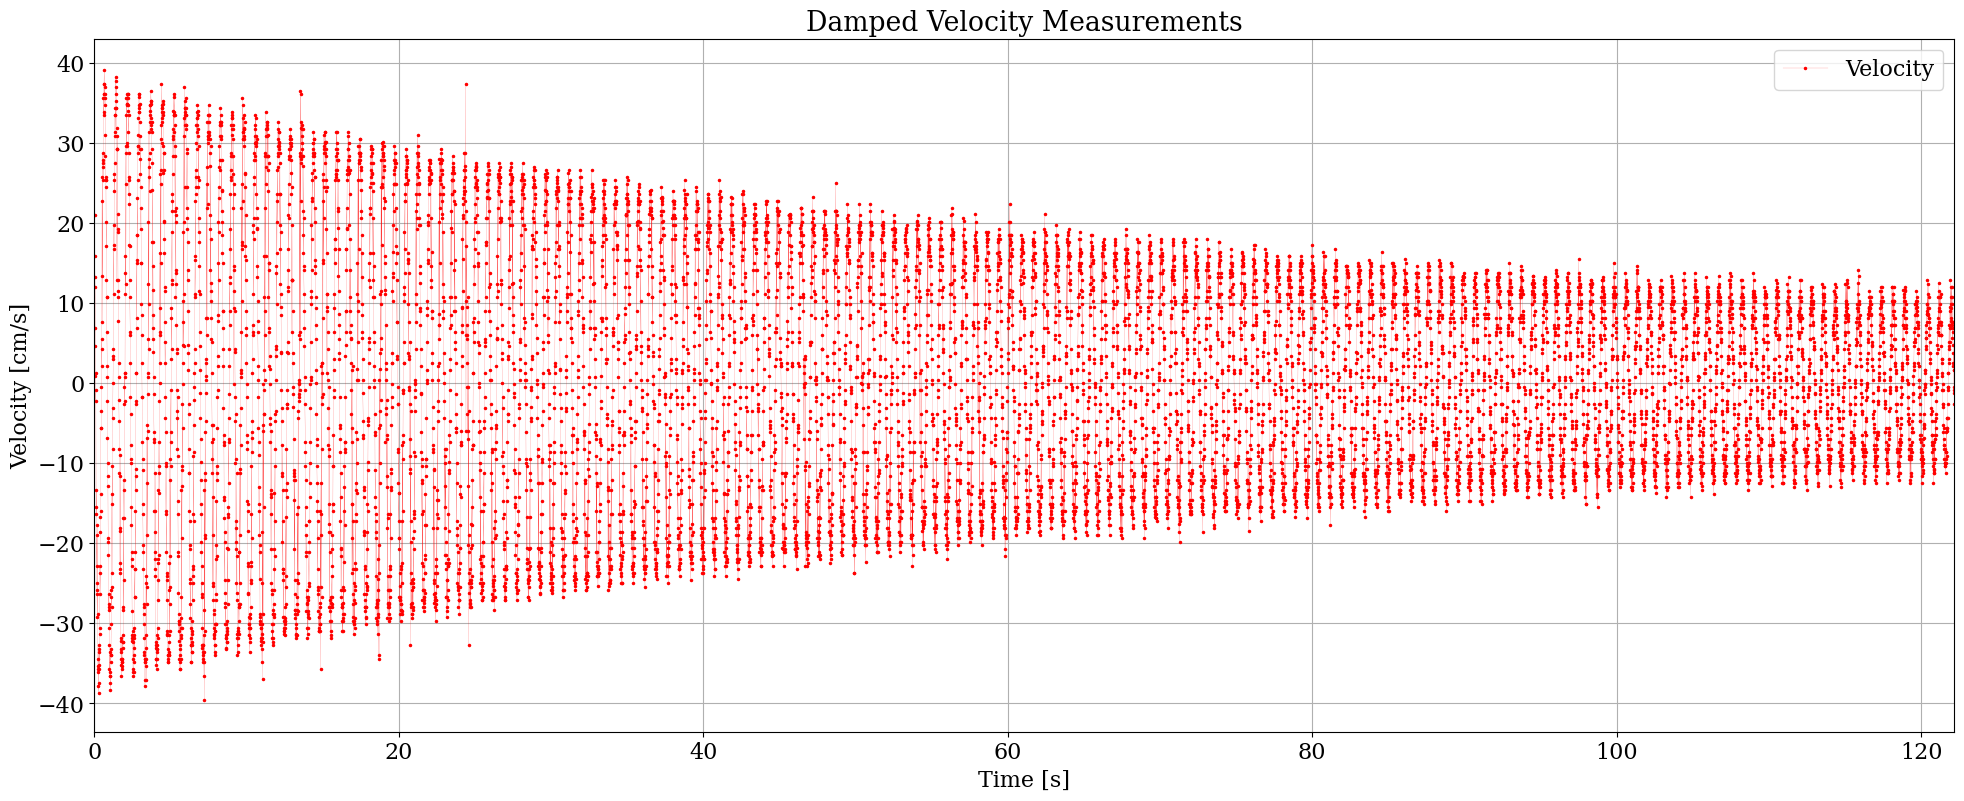

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 16, 'figure.figsize': (18, 6), 'font.family': 'serif'})

# Experimental Data Analysis
m1 = 200.3 # g, w/o disk (undamped)
m2 = 217.1 # g, w/ disk (damped)

pos_header = ['time','dist','err']
vel_header = ['time','vel']
undamped_pos_data = np.genfromtxt('pos_undamped.txt', skip_header=2, delimiter="", names=pos_header)
undamped_vel_data = np.genfromtxt('vel_undamped.txt', skip_header=2, delimiter="", names=vel_header)
damped_pos_data = np.genfromtxt('pos_damped.txt', skip_header=2, delimiter="", names=pos_header)
damped_vel_data = np.genfromtxt('vel_damped.txt', skip_header=2, delimiter="", names=vel_header)

# undamped
undamped_pos = undamped_pos_data['dist'] - np.median(undamped_pos_data['dist'])
undamped_pos_err = undamped_pos_data['err']
undamped_pos_time = undamped_pos_data['time']
undamped_vel = undamped_vel_data['vel']
undamped_vel_time = undamped_vel_data['time']

# damped 
damped_pos = damped_pos_data['dist'] - np.median(damped_pos_data['dist'])
damped_pos_err = damped_pos_data['err']
damped_pos_time = damped_pos_data['time']
damped_vel = damped_vel_data['vel']
damped_vel_time = damped_vel_data['time']

def plot_pos(time, pos, pos_err,title):
    fig = plt.figure(figsize=(24,9))
    plt.title(title)
    plt.xlim(min(time), max(time))
    plt.errorbar(time, pos, yerr=pos_err, fmt='o', label="Position & Uncertainty", linestyle='', capsize=1.5, markersize=1.25, c="red",capthick=0.3, elinewidth=0.2, ecolor='blue')
    plt.xlabel("Time [s]")
    plt.ylabel("Position [cm]")
    plt.legend()
    plt.grid()
    return fig

def plot_vel(time, vel, title):
    fig = plt.figure(figsize=(24,9))
    plt.title(title)
    plt.xlim(min(time), max(time))
    plt.plot(time, vel, label="Velocity", c="red", marker=".", markersize=3, lw=0.1)
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity [cm/s]")
    plt.legend()
    plt.grid()
    return fig

plot_pos(undamped_pos_time, undamped_pos, undamped_pos_err, "Undamped Position Measurements").savefig("undamped_measurement.pdf")
plot_pos(damped_pos_time, damped_pos, damped_pos_err, "Damped Position Measurements").savefig("damped_measurement.pdf")
plot_vel(undamped_vel_time, undamped_vel, "Undamped Velocity Measurements").savefig("undamped_velocity.pdf")
plot_vel(damped_vel_time, damped_vel, "Damped Velocity Measurements").savefig("damped_velocity.pdf")


In [14]:
# # Uncomment to check that peak finding for period and decay constant is working
# undamped_peaks = find_peaks(undamped_pos, width=4)[0]
# damped_peaks = find_peaks(damped_pos, width=4)[0]
# fig = plt.figure(figsize=(16,4))
# plt.title("Peaks")
# plt.plot(damped_pos_time, damped_pos, label="Damped Position")
# plt.scatter(damped_pos_time[damped_peaks], damped_pos[damped_peaks], label="Peaks", c="red",s=20,marker="x")
# plt.xlabel("Time [s]")
# plt.ylabel("Position [cm]")
# plt.legend()
# plt.grid()
# fig = plt.figure(figsize=(16,4))
# plt.title("Peaks")
# plt.plot(undamped_pos_time, undamped_pos, label="Undamped Position")
# plt.scatter(undamped_pos_time[undamped_peaks], undamped_pos[undamped_peaks], label="Peaks", c="red",s=20,marker="x")
# plt.xlabel("Time [s]")
# plt.ylabel("Position [cm]")
# plt.legend()
# plt.grid()

def period(time, pos, starting_peak=10):
    peaks = find_peaks(pos, width=4)[0]
    print(f"Using peaks {starting_peak} to {len(peaks)} to calculate period")
    return (time[peaks[starting_peak:]][-1] - time[peaks[starting_peak:]][0]) / (len(peaks[starting_peak:]) - 1)

# Decay constant 
def decay_constant(time, pos):
    peaks = find_peaks(pos, width=4)[0]
    amplitudes = np.abs(pos[peaks])
    search_value = (1/np.e) * amplitudes[0]
    amplitude_times = time[peaks]
    found_index = np.where(amplitudes - search_value < 0.0001)[0][0]
    found_time = amplitude_times[found_index]
    gamma = 2 / found_time
    return found_time, gamma

undamped_period = period(undamped_pos_time, undamped_pos)
undamped_omega_0 = (2 * np.pi) / undamped_period
k_undamped = undamped_omega_0**2 * (m1/1000)
print("Undamped Period:", undamped_period)
print("Undamped Angular Frequency:", undamped_omega_0)
print("Undamped Spring Constant:", k_undamped)
print("--------------------")
damped_period = period(damped_pos_time, damped_pos, 150)
damped_omega_0 = (2 * np.pi) / damped_period
k_damped = damped_omega_0**2 * (m2/1000)
damped_decay_time, damped_decay_const = decay_constant(damped_pos_time, damped_pos)
print("Damped Period:", damped_period)
print("Damped Angular Frequency:", damped_omega_0)
print("Damped Spring Constant:", k_damped)
print(f"Damped Decay Constant: {damped_decay_const} found at t = {damped_decay_time}s")

Using peaks 10 to 23 to calculate period
Undamped Period: 0.7324999999999999
Undamped Angular Frequency: 8.577727381815135
Undamped Spring Constant: 14.73755462945925
--------------------
Using peaks 150 to 165 to calculate period
Damped Period: 0.7071428571428575
Damped Angular Frequency: 8.885312555607491
Damped Spring Constant: 17.139779966672524
Damped Decay Constant: 0.022192632046160673 found at t = 90.12s


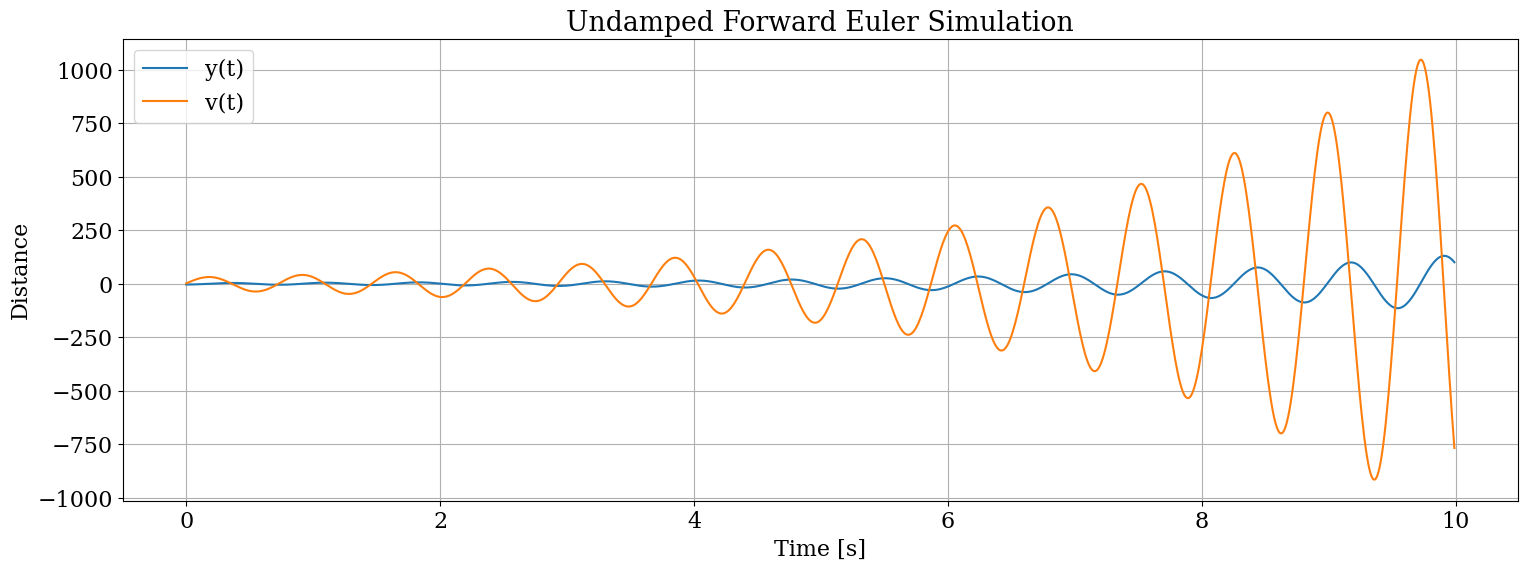

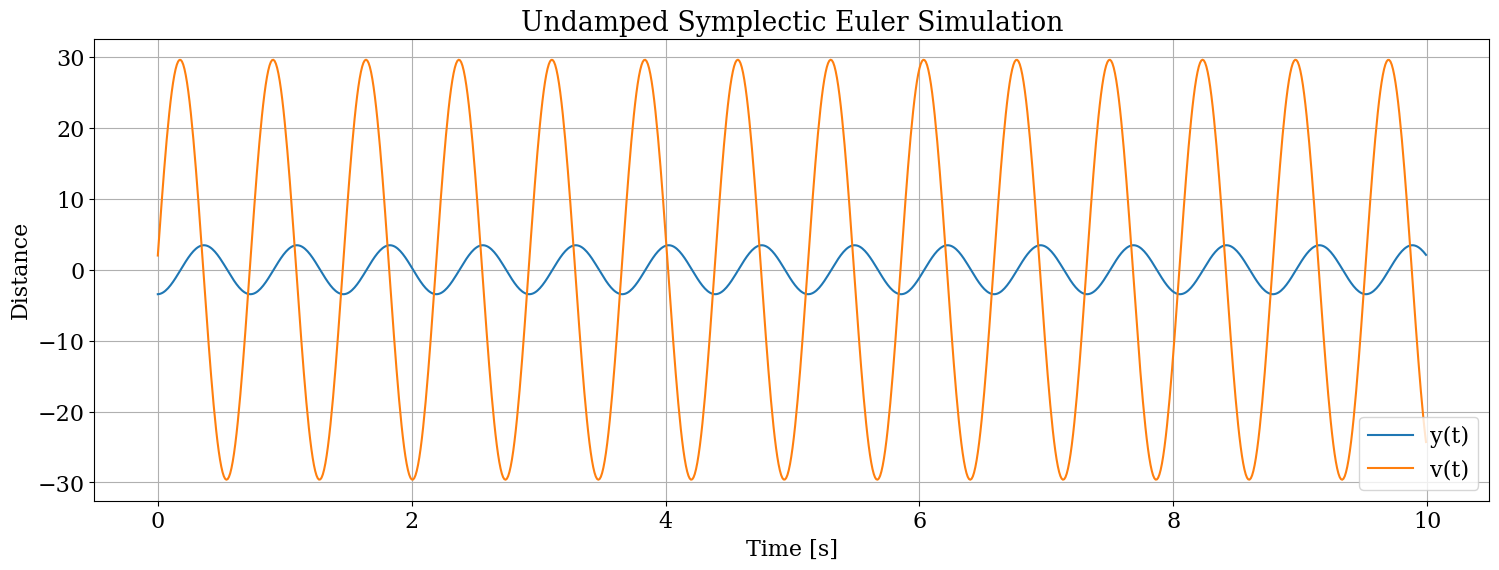

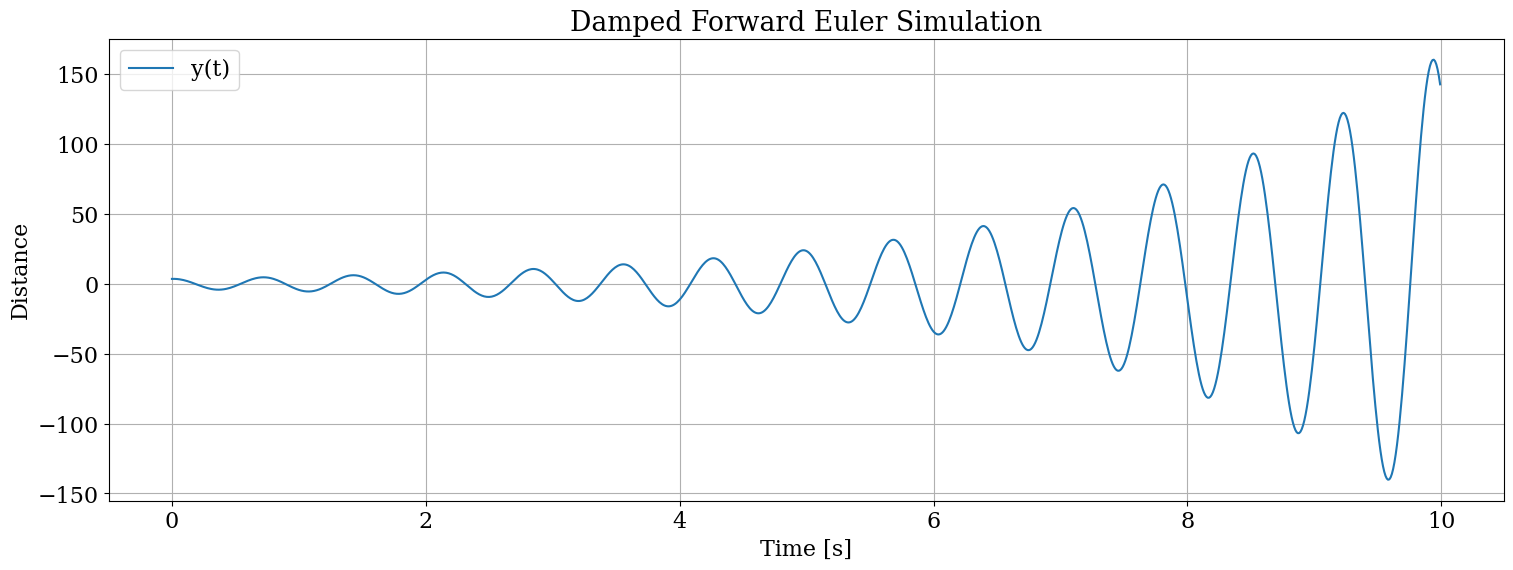

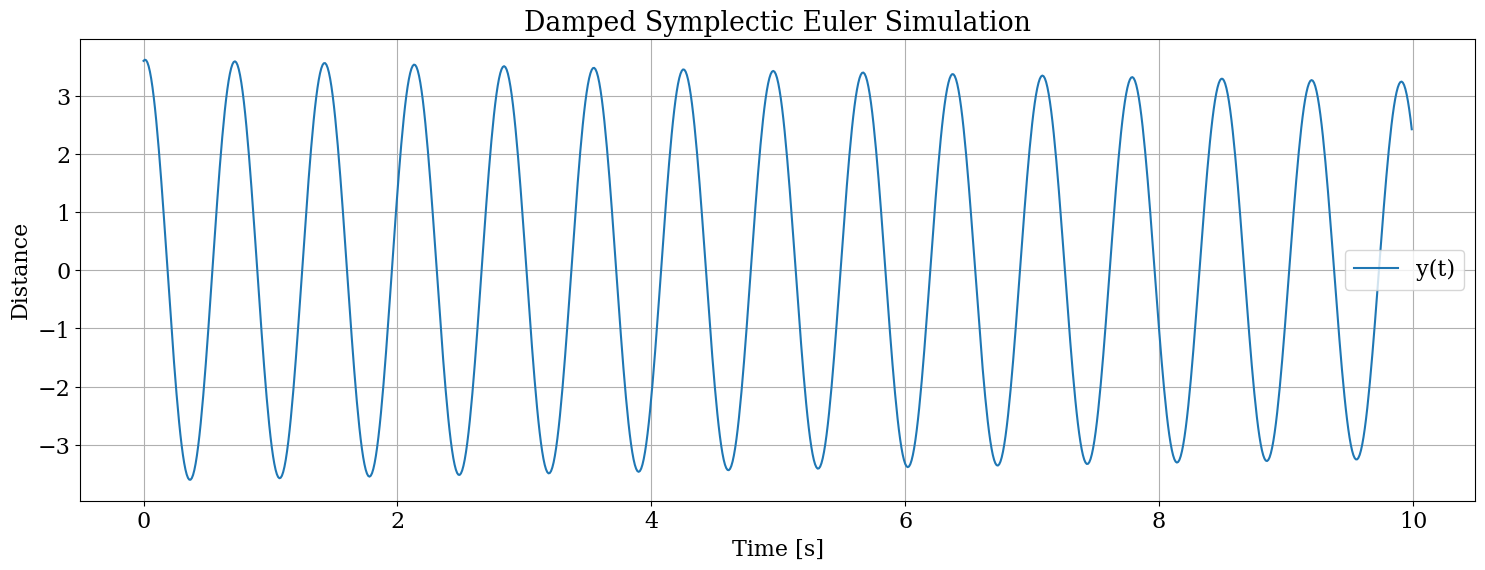

In [15]:
# Simulation
dt = 0.01
gamma = damped_decay_const
y_0_damped = damped_pos[0]
y_0_undamped = undamped_pos[0]
v_0 = 2 
t_max = 10

def forward_euler(y_0, v_0, omega_0, dt, t_max):
    t = np.arange(0,t_max,dt)
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*omega_0**2*y[i-1]
    return y, v, t

def symplectic_euler(y_0, v_0, omega_0, dt, t_max):
    t = np.arange(0,t_max,dt)
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*omega_0**2*y[i]
    return y, v, t

def forward_euler_damped(y_0, v_0, omega_0, gamma, dt, t_max):
    t = np.arange(0,t_max,dt)
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - (omega_0**2*y[i-1] + gamma*v[i-1])*dt
    return y, v, t

def symplectic_euler_damped(y_0, v_0, omega_0, gamma, dt, t_max):
    t = np.arange(0,t_max,dt)
    y = np.zeros(len(t))
    v = np.zeros(len(t))  
    y[0] = y_0
    v[0] = v_0
    for i in range(1,len(t)):
        y[i] = y[i-1] + dt*v[i-1]
        v[i] = v[i-1] - dt*(omega_0**2*y[i] + gamma*v[i-1])
    return y, v, t

y, v, t = forward_euler(y_0_undamped, v_0, undamped_omega_0, dt, t_max)
fig = plt.figure()
plt.title("Undamped Forward Euler Simulation")
plt.plot(t,y, label="y(t)")
plt.plot(t,v, label="v(t)")
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
fig.savefig("undamped_forward.pdf")

y_sym, v_sym, t_sym = symplectic_euler(y_0_undamped, v_0, undamped_omega_0, dt, t_max)
fig = plt.figure()
plt.title("Undamped Symplectic Euler Simulation")
plt.plot(t_sym,y_sym, label="y(t)")
plt.plot(t_sym,v_sym, label="v(t)")
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
fig.savefig("undamped_symplectic.pdf")

y, v, t = forward_euler_damped(y_0_damped, v_0, damped_omega_0,gamma,dt, t_max)
fig = plt.figure()
plt.title("Damped Forward Euler Simulation")
plt.plot(t,y, label="y(t)")
#plt.plot(t,v, label="v(t)")
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
fig.savefig("damped_forward.pdf")

y_sym, v_sym, t_sym = symplectic_euler_damped(y_0_damped, v_0, damped_omega_0,gamma, dt, t_max)
fig = plt.figure()
plt.title("Damped Symplectic Euler Simulation")
plt.plot(t_sym,y_sym, label="y(t)")
#plt.plot(t_sym,v_sym, label="v(t)")
plt.xlabel("Time [s]")
plt.ylabel("Distance")
plt.legend()
plt.grid()
fig.savefig("damped_symplectic.pdf")

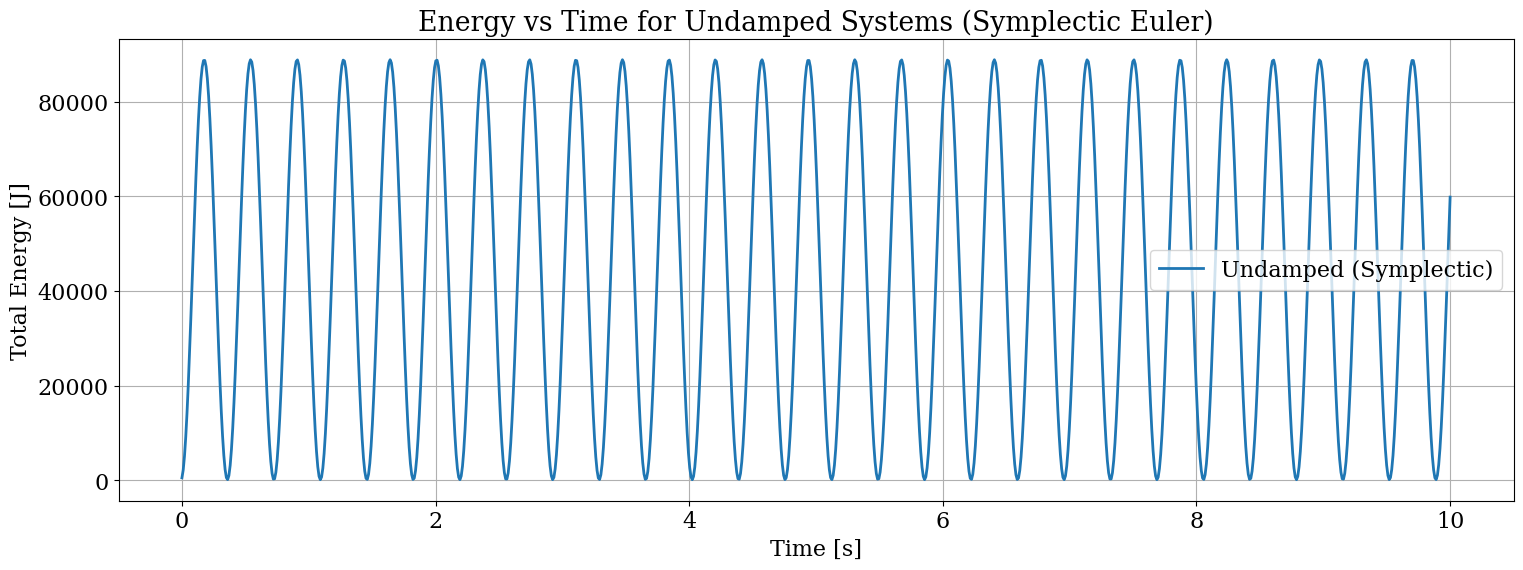

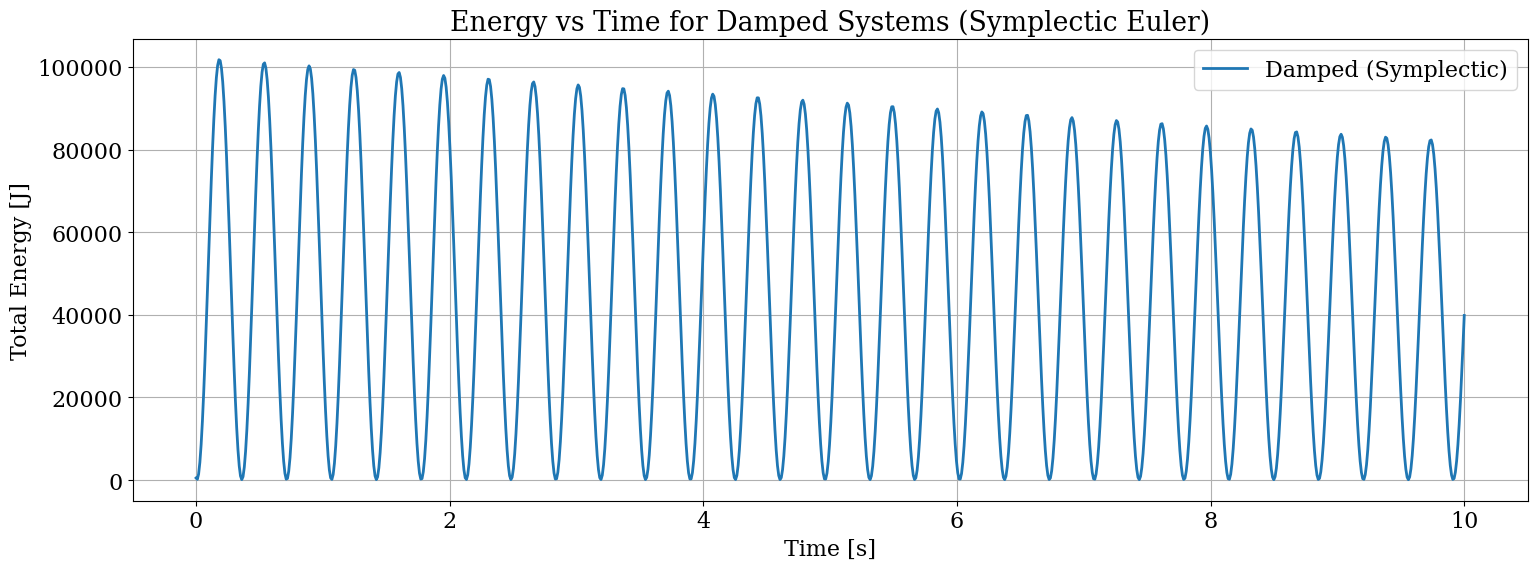

In [22]:
# Energy 
k_undamped = undamped_omega_0**2 * (m1/1000)
k_damped = undamped_omega_0**2 * (m2/1000)
def symplectic_euler_energy(y_0, v_0, omega_0, dt, t_max, damped=False):
    t = np.linspace(0, t_max, int(t_max / dt))
    y = np.zeros(len(t))
    v = np.zeros(len(t))
    E_tot = np.zeros(len(t))
    y[0] = y_0
    v[0] = v_0
    if damped:
        E_tot[0] = 0.5 * m1 * v_0**2 + 0.5 * k_damped * y_0**2
        for i in range(1, len(t)):
            v[i] = v[i - 1] - dt * (omega_0**2 * y[i - 1] + gamma * v[i - 1])
            y[i] = y[i - 1] + dt * v[i]
            E_tot[i] = 0.5 * m1 * v[i]**2 + 0.5 * k_damped * y[i]**2
    else:
        E_tot[0] = 0.5 * m1 * v_0**2 + 0.5 * k_undamped * y_0**2
        for i in range(1, len(t)):
            v[i] = v[i - 1] - dt * omega_0**2 * y[i - 1]
            y[i] = y[i - 1] + dt * v[i]
            E_tot[i] = 0.5 * m1 * v[i]**2 + 0.5 * k_undamped * y[i]**2
    return t, E_tot

t_undamped_sym, E_tot_undamped_sym = symplectic_euler_energy(y_0_undamped, v_0, undamped_omega_0, dt, t_max, damped=False)
t_damped_sym, E_tot_damped_sym = symplectic_euler_energy(y_0_damped, v_0, damped_omega_0, dt, t_max, damped=True)

plt.figure()
plt.title("Energy vs Time for Undamped Systems (Symplectic Euler)")
plt.plot(t_undamped_sym, E_tot_undamped_sym, label='Undamped (Symplectic)', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Total Energy [J]")
plt.legend()
plt.grid()

plt.figure()
plt.title("Energy vs Time for Damped Systems (Symplectic Euler)")
plt.plot(t_damped_sym, E_tot_damped_sym, label='Damped (Symplectic)', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Total Energy [J]")
plt.legend()
plt.grid()